# What is torch.nn really ?

Source :https://pytorch.org/tutorials/beginner/nn_tutorial.html


PyTorch provides the elegantly designed modules and classes `torch.nn , torch.optim , Dataset , and DataLoader` to help you create and train neural networks. In order to fully utilize their power and customize them for your problem, you need to really understand exactly what they’re doing. To develop this understanding, we will first train basic neural net on the `MNIST` data set without using any features from these models; we will initially only use the most basic PyTorch tensor functionality. Then, we will incrementally add one feature from `torch.nn, torch.optim, Dataset, or DataLoader` at a time, showing exactly what each piece does, and how it works to make the code either more concise, or more flexible.

## MNIST data setup
We will use the classic MNIST dataset, which consists of black-and-white images of hand-drawn digits (between 0 and 9).


We will use **pathlib** for dealing with paths (part of the Python 3 standard library), and will download the dataset using requests. We will only import modules when we use them, so you can see exactly what’s being used at each point.



In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH/ "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not(PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

The datasets is numpy array format, and has been stored using **pickle** - a python-spwcific format for serializing data

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)


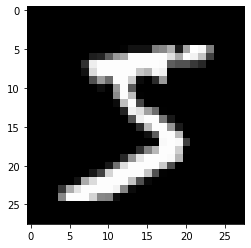

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
print(x_train.shape)

In [4]:
import torch

#Convert numpy array to torch.tensor
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Neural net from scratch (no torch.nn)

First create a model using nothing but PyTorch tensor operations. We’re assuming you’re already familiar with the basics of neural networks.
PyTorch provides methods to create random or zero-filled tensors, which we will use to create our weights and bias for a simple linear model

For the `weights`, we set `requires_grad` after the initialization, since we don’t want that step included in the gradient. (Note that a trailling `_` in PyTorch signifies that the operation is performed in-place.)

_We are initializing the `weights` here with Xavier initialisation (by multiplying with `1/sqrt(n))`._

In [5]:
import math
weights = torch.randn(784, 10)/math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [6]:
weights

tensor([[ 0.0006,  0.0091, -0.0092,  ..., -0.0414,  0.0497,  0.0130],
        [-0.0328,  0.0200, -0.0397,  ...,  0.0265,  0.0079, -0.0028],
        [ 0.0158, -0.0177,  0.0320,  ..., -0.0334, -0.0018, -0.0228],
        ...,
        [ 0.0131,  0.0561, -0.0586,  ..., -0.0061,  0.0058,  0.0838],
        [ 0.0423, -0.0387,  0.0060,  ...,  0.0850, -0.0106, -0.0223],
        [-0.0079, -0.0112, -0.0172,  ..., -0.0539, -0.0024,  0.0280]],
       requires_grad=True)

In [7]:
bias

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

PyTorch’s ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model!So let’s just write a plain matrix multiplication and broadcasted addition to create a simple linear model. We also need an activation function, so we’ll write log_softmax and use it. 

In [8]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)
    
def model(xb):
    return log_softmax(xb @ weights + bias)

In the above, the `@` stands for the dot product operation.

We will call our function on one batch of data (in this case, 64 images). This is one forward pass. Note that our predictions won’t be any better than random at this stage, since we start with random weights

In [9]:
bs = 64

xb = x_train[0:bs] # a mini-batch from x
preds = model(xb) #predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.5504, -2.4947, -1.5572, -2.5953, -2.2826, -2.4573, -1.9340, -2.3891,
        -2.5145, -3.0115], grad_fn=<SelectBackward>) torch.Size([64, 10])


As you see, the preds tensor contains not only the tensor values, but also a gradient function. We’ll use this later to do backprop.

Let’s implement negative log-likelihood to use as the loss function (again, we can just use standard Python):

In [10]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Let’s check our loss with our random model, so we can see if we improve after a backprop pass later.

In [12]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.2940, grad_fn=<NegBackward>)


Let’s also implement a function to calculate the accuracy of our model. For each prediction, if the index with the largest value matches the target value, then the prediction was correct.

In [13]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

In [14]:
print(accuracy(preds, yb))

tensor(0.0781)


We can now run a training loop. For each iteration, we will:

- select a mini-batch of data (of size `bs`)
- use the model to make predictions
- calculate the `loss`
- `loss.backward()` updates the gradients of the model, in this case, `weights` and `bias`

We now use these gradients to update the weights and bias. We do this within the `torch.no_grad()` context manager, because we do not want these actions to be recorded for our next calculation of the gradient

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. `loss.backward()` adds the gradients to whatever is already stored, rather than replacing them).



In [15]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        #set trace()
        start_i = i * bs
        end_i = start_i * bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad*lr
            bias -= bias.grad*lr
            weights.grad.zero_()
            bias.grad.zero_()

That’s it: we’ve created and trained a minimal neural network (in this case, a logistic regression, since we have no hidden layers) entirely from scratch!

Let’s check the loss and accuracy and compare those to what we got earlier. We expect that the loss will have decreased and accuracy to have increased, and they have.

In [16]:
print(loss_func(model(xb), yb))
print(accuracy(model(xb), yb))

tensor(0.0470, grad_fn=<NegBackward>)
tensor(1.)


## Using torch.nn.functional

In [17]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

Note that we no longer call `log_softmax` in the `model` function. Let’s confirm that our loss and accuracy are the same as before:

In [19]:
print(loss_func(model(xb), yb))
print(accuracy(model(xb), yb))

tensor(0.0470, grad_fn=<NllLossBackward>)
tensor(1.)


## Refactor using nn.Module